# Imports

put comments here related to library management

In [21]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models
from IPython import display

from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, GlobalAveragePooling2D, Dense, Activation, Input, Reshape, Multiply, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, ReLU, Dropout
from tensorflow.keras import Sequential

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.keras.compat import keras
from keras.layers import Resizing
from tensorflow_model_optimization.quantization.keras import quantize_annotate_layer
import tempfile

import nbimporter

# Run .py preprocessing that sets up the datasets

In [22]:
# Function to parse a single serialized example from TFRecord
def _parse_function(proto):
    # Define the feature description (same as the structure you used when saving)
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),  # Image is stored as a string
        'label': tf.io.FixedLenFeature([], tf.int64),   # Label is an int64
    }
    
    # Parse the input `tf.train.Example` proto using the feature description
    parsed_example = tf.io.parse_single_example(proto, feature_description)
    
    # Decode the JPEG-encoded image back into a float32 tensor
    image = tf.io.decode_jpeg(parsed_example['image'], channels=1)  # Grayscale
    image = tf.image.convert_image_dtype(image, tf.float32)  # Convert to [0, 1] range
    
    # Reshape the image to its original shape (e.g., [124, 129, 1])
    image = tf.reshape(image, [124, 129, 1])
    
    # Get the label
    label = parsed_example['label']
    
    return image, label

In [23]:
# Function to load the dataset from a TFRecord file
def load_dataset(tfrecord_file, batch_size=64):
    # Load the TFRecord file
    raw_dataset = tf.data.TFRecordDataset(tfrecord_file)
    
    # Parse the serialized data using the _parse_function
    parsed_dataset = raw_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and shuffle the dataset (optional, depending on your needs)

    parsed_dataset = parsed_dataset.shuffle(buffer_size=1000).batch(batch_size)
    parsed_dataset = parsed_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return parsed_dataset

In [24]:
# Load the train, test, and validation datasets from TFRecord files
train_spectrogram_ds = load_dataset('train_spec_ds.tfrecord')
test_spectrogram_ds = load_dataset('test_spec_ds.tfrecord')
val_spectrogram_ds = load_dataset('val_spec_ds.tfrecord')

In [25]:
new_size = len(list(train_spectrogram_ds))
print(f"New dataset size: {new_size}")

# Get input shape and number of classes
for spectrograms, labels in train_spectrogram_ds.take(1):
    input_shape = spectrograms.shape
    num_classes = 6
    print('Input shape:', input_shape)
    print('Number of classes:', num_classes)

New dataset size: 213
Input shape: (64, 124, 129, 1)
Number of classes: 6


In [26]:
new_size = len(list(test_spectrogram_ds))
print(f"New dataset size: {new_size}")

New dataset size: 27


# Define models

In [27]:
import audio_models

# Weight initializations?

## Train Models


Training Model 0
Model: "CNN2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_annotate_2 (Quant  (None, 32, 32, 1)         0         
 izeAnnotate)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 15, 15, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 7200)              0         
                                                                 
 dense_4 (Dense)             (None, 64)     

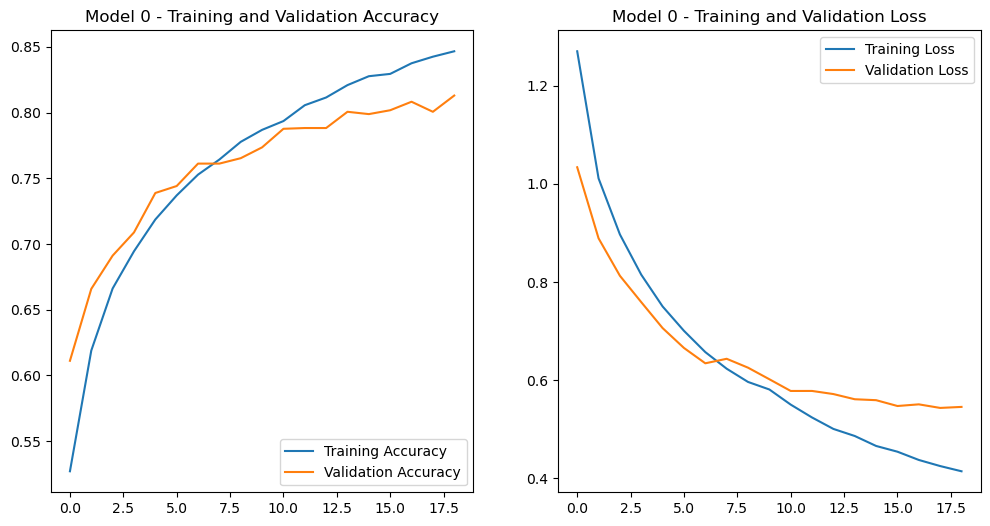


Training Model 1
Model: "tiny_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 flatten (Flatten)           (None, 32240)             0         
                                                                 
 fc2 (Dense)                 (None, 6)                 193446    
                                                                 
Total params: 194094 (758.18 KB)
Trainable params: 194094 (758.18 KB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________________

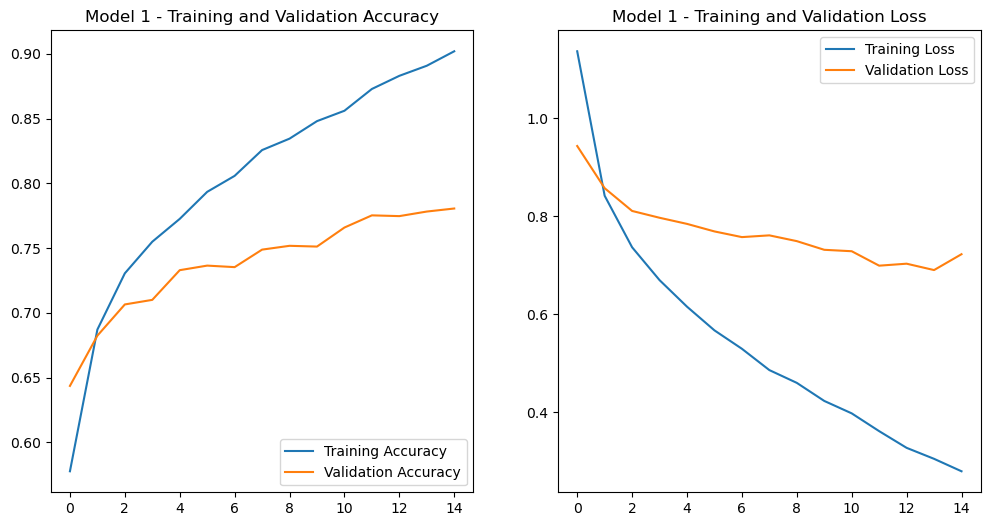


Training Model 2
Model: "tiny_embed_conv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 65, 8)         648       
                                                                 
 relu1 (ReLU)                (None, 62, 65, 8)         0         
                                                                 
 dropout1 (Dropout)          (None, 62, 65, 8)         0         
                                                                 
 conv2 (Conv2D)              (None, 8, 9, 8)           5128      
                                                                 
 relu2 (ReLU)                (None, 8, 9, 8)           0         
                                                                 
 dropout2 (Dropout)          (None, 8, 9, 8)           0         
                                                                 
 flatten (Flatten)         

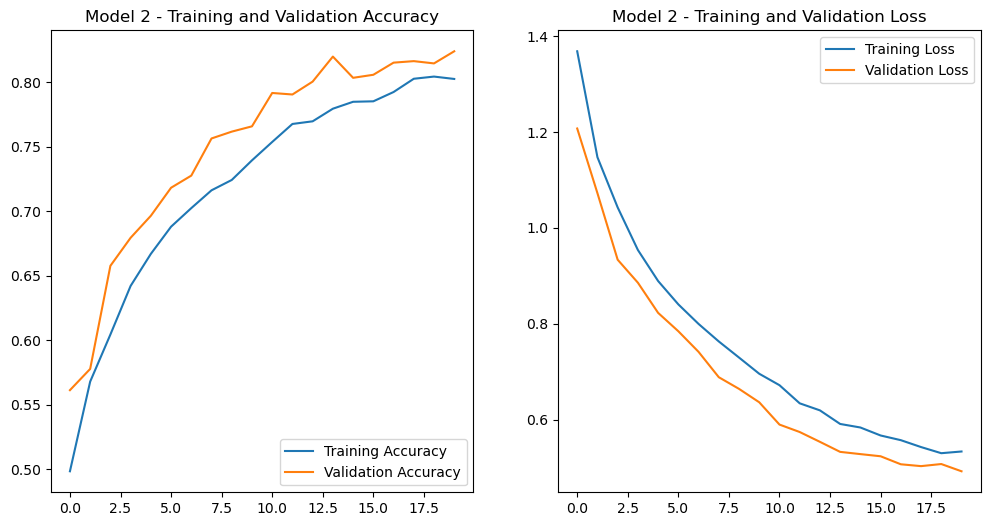


Training Model 3
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         
                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
                                                                 
 flatten (Flatten)    

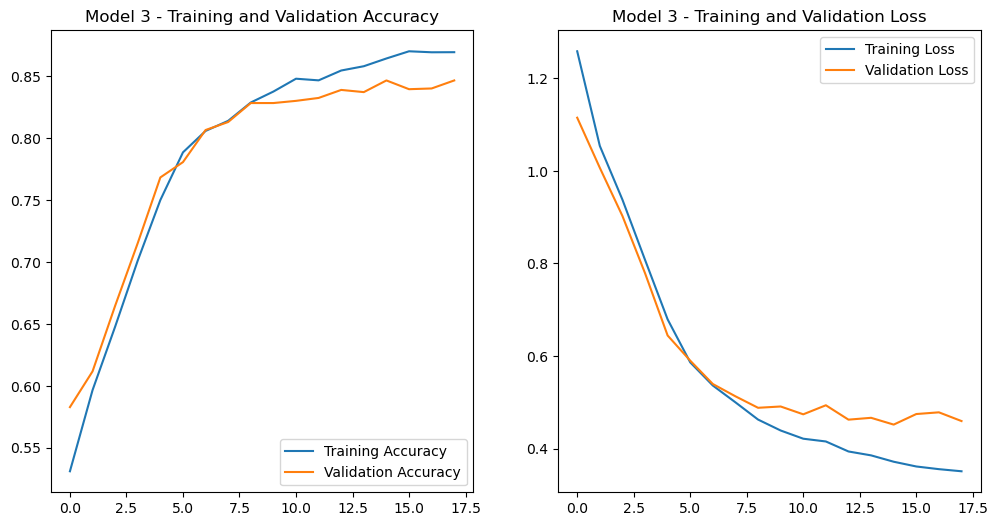

In [28]:
models = []
histories = []
sequential_models = True

for i, create_model in enumerate([audio_models.create_model_2, 
                                audio_models.create_tiny_conv_model_small, audio_models.create_tiny_embed_conv_model_small,
                                audio_models.create_tiny_embed_conv_model_small_best]):
    print(f'\nTraining Model {i}')
    input_shape = (124, 129, 1)
    model = create_model(input_shape)
    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    model.summary()


    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=20,  # You can adjust the number of epochs
        callbacks=keras.callbacks.EarlyStopping(verbose=1, patience=3, min_delta=0.01),
        verbose = 1
    )
    models.append(model)
    histories.append(history)
    audio_models.plot_training_history(history, i)


## Compile and test models

27/27 [==============================] - 0s 5ms/step - loss: 0.5164 - accuracy: 0.8088
Total non-trainable parameters: 0.0
Total trainable parameters: 461574
Model 1 Test Accuracy: 0.8088
27/27 [==============================] - 0s 6ms/step - loss: 0.6353 - accuracy: 0.8000
Total non-trainable parameters: 0.0
Total trainable parameters: 194094
Model 2 Test Accuracy: 0.8000
27/27 [==============================] - 0s 7ms/step - loss: 0.4652 - accuracy: 0.8306
Total non-trainable parameters: 0.0
Total trainable parameters: 9238
Model 3 Test Accuracy: 0.8306
27/27 [==============================] - 0s 13ms/step - loss: 0.4390 - accuracy: 0.8371
Total non-trainable parameters: 0.0
Total trainable parameters: 36082
Model 4 Test Accuracy: 0.8371


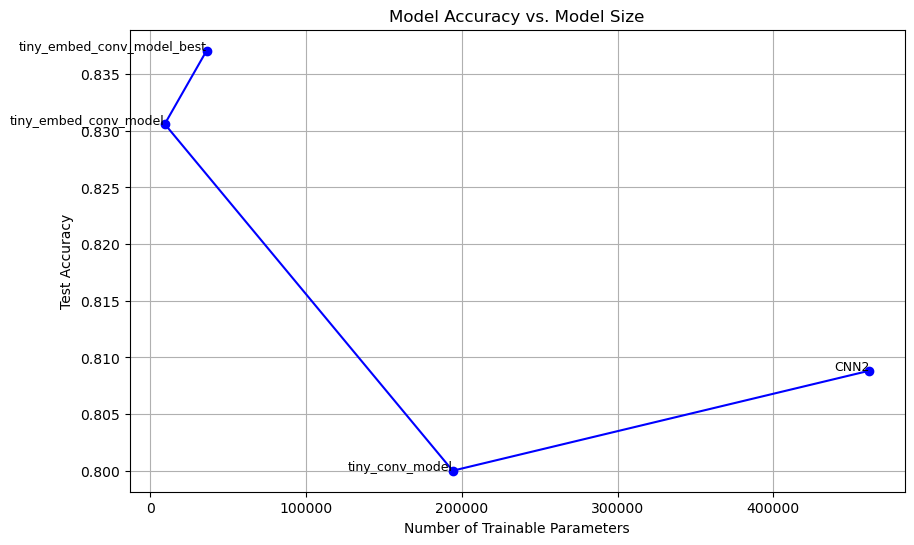

In [31]:
# List to store the results
accuracies = []
model_sizes = []
model_names = []

# Evaluate each model and store the results
for i, model in enumerate(models, start=1):
    test_loss, test_acc = model.evaluate(test_spectrogram_ds)
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    
    # Print the details
    print(f"Total non-trainable parameters: {non_trainable_params}")
    print(f"Total trainable parameters: {trainable_params}")
    print(f'Model {i} Test Accuracy: {test_acc:.4f}')
    
    # Store the accuracy and model size
    accuracies.append(test_acc)
    model_sizes.append(trainable_params)
    model_names.append(model.name)

# Plotting accuracy vs. model size
plt.figure(figsize=(10, 6))
plt.plot(model_sizes, accuracies, marker='o', linestyle='-', color='b')

for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=9, ha='right')

# Add labels and title
plt.xlabel('Number of Trainable Parameters')
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy vs. Model Size')

# Display the plot
plt.grid(True)
plt.show()


# Shrinking the model

[deployment on the edge](https://ai.google.dev/edge/litert)

[general model optimizations](https://www.tensorflow.org/model_optimization/guide)

We will start off with pruning

we will aslo try quantization aware training to quantize the model
and we will also try different post-training quantizations

we can also try weight clustering

and finalyl we will try a single workflow with a combination of the previous methods
[collaborative optimizations](https://www.tensorflow.org/model_optimization/guide/combine/collaborative_optimization)


https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html



# Pruning

## Pure Pruning (dont work rn fix)

In [30]:
def apply_pruning_to_dense(layer):
    if isinstance(layer, tf.keras.models.Sequential):  #tf.keras.models.Sequential
        # Apply pruning to Dense layers
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    return layer

# Ensure you have set the appropriate pruning schedule
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.0,
        final_sparsity=0.5,
        begin_step=0,
        end_step=1000
    )
}

for model in models:
    # Apply pruning to the model by cloning and using the pruning function
    model_for_pruning = tf.keras.models.clone_model(
        model,
        clone_function=apply_pruning_to_dense
    )

    # Compile the pruned model (necessary before training)
    model_for_pruning.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Print the pruned model's summary
    model_for_pruning.summary()

# Make sure to include the pruning callbacks during training
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()
]

# Example of how to train the pruned model
# history = model_for_pruning.fit(train_dataset, epochs=10, callbacks=callbacks, validation_data=val_dataset)


ValueError: Arguments `clone_function` and `input_tensors` are only supported for Sequential models or Functional models. Received model of type 'Sequential', with clone_function=<function apply_pruning_to_dense at 0x000002B20426F6A0> and input_tensors=None

## Pruning preserving quantization aware training (PQAT)
https://www.tensorflow.org/model_optimization/guide/combine/pqat_example

## Sparsity and cluster preserving quantization aware training
https://www.tensorflow.org/model_optimization/guide/combine/pcqat_example

# Quantize models

https://www.tensorflow.org/model_optimization/guide

https://blog.tensorflow.org/2024/04/faster-dynamically-quantized-inference-with-xnnpack.html


we can also add some weight clustering?

## quantization aware training
https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://www.tensorflow.org/model_optimization/guide/quantization/training_comprehensive_guide#quantize_some_layers

In [32]:
#import tensorflow_model_optimization as tfmot

#quantization aware training with int8 weights and uint8 activations.
def qat(model):
  # translate model to be quantization aware
  quantize_model = tfmot.quantization.keras.quantize_model

  # Use `quantize_scope` to register the custom NoOpQuantizeConfig object
  with tfmot.quantization.keras.quantize_scope({'NoOpQuantizeConfig': audio_models.NoOpQuantizeConfig}):
      # Annotate the model for QAT
      quant_aware_annotated_model = tfmot.quantization.keras.quantize_annotate_model(model)
      
      # Apply QAT
      q_aware_model = tfmot.quantization.keras.quantize_apply(quant_aware_annotated_model)



  # Debug: Print model type and structure
  print(f"Model type: {type(model)}")
  print(f"Is Sequential: {isinstance(model, tf.keras.Sequential)}")
  print(f"Is Functional: {hasattr(model, '_is_graph_network') and model._is_graph_network}")
  model.summary()

  # Check if the model is Sequential or Functional
  if not isinstance(model, tf.keras.Sequential) and not (hasattr(model, '_is_graph_network') and model._is_graph_network):
    raise ValueError('`model` must be a Keras Sequential or Functional model.')

  #q_aware_model = quantize_model(quant_aware_model)

  q_aware_model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
  
  q_aware_model.summary()

  num_batches = tf.data.experimental.cardinality(train_spectrogram_ds).numpy()
  print(f"Number of batches in the training dataset: {num_batches}")

  # finetune quant aware model with quant aware training
  q_aware_model.fit(train_spectrogram_ds.take(num_batches // 4), batch_size = 100, epochs=1, validation_data=val_spectrogram_ds)

  _, baseline_model_accuracy = model.evaluate(test_spectrogram_ds, verbose=0)

  _, q_aware_model_accuracy = q_aware_model.evaluate(test_spectrogram_ds, verbose=0)

  print('Baseline test accuracy:', baseline_model_accuracy)
  print('Quant test accuracy:', q_aware_model_accuracy)

  # now we haveint8 weights and uint8 activations.
  # Convert the model to TFLite
  converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]

  quantized_tflite_model = converter.convert()

  model_filename = f'qat_{model.name}.tflite'
  # Save the quantized model
  with open(model_filename, 'wb') as f:
    f.write(quantized_tflite_model)

  return quantized_tflite_model


In [33]:
# Evaluate the TFLite quantized model
def evaluate_tflite_model(interpreter, dataset):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    total_samples = 0
    correct_predictions = 0

    for spectrograms, labels in dataset:
        input_data = spectrograms.numpy().astype('float32')
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        predictions = interpreter.get_tensor(output_details[0]['index'])
        predicted_labels = tf.argmax(predictions, axis=1)
        correct_predictions += tf.reduce_sum(tf.cast(predicted_labels == labels, tf.int32)).numpy()
        total_samples += labels.shape[0]

    accuracy = correct_predictions / total_samples
    return accuracy

In [34]:
model = models[3]
#input_shape = (124, 129, 1)
#inputs = tf.keras.Input(shape=(input_shape))
#outputs = model(inputs)
#functional_model = tf.keras.Model(inputs, outputs)

qat_tflite_model = qat(model)

# Evaluate the TFLite quantized model
interpreter = tf.lite.Interpreter(model_content=qat_tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


'''fix this'''
#quantized_model_accuracy = evaluate_tflite_model(interpreter, test_spectrogram_ds)
#print('Quantized TFLite model test accuracy:', quantized_model_accuracy)


c:\Users\adamk\anaconda3\Lib\site-packages\tf_keras\src\initializers\__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'keras.src.initializers.random_initializers.TruncatedNormal'>, which may lead to improper serialization.
  warnings.warn(


Model type: <class 'tf_keras.src.engine.sequential.Sequential'>
Is Sequential: False
Is Functional: True
Model: "tiny_embed_conv_model_best"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 129, 16)       1312      
                                                                 
 relu1 (ReLU)                (None, 62, 129, 16)       0         
                                                                 
 dropout1 (Dropout)          (None, 62, 129, 16)       0         
                                                                 
 conv2 (Conv2D)              (None, 16, 22, 12)        9420      
                                                                 
 relu2 (ReLU)                (None, 16, 22, 12)        0         
                                                                 
 dropout2 (Dropout)          (None, 16, 22, 12)        0         
 

INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmper64gkiq\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


'fix this'

In [35]:

# Create float TFLite model.
float_converter = tf.lite.TFLiteConverter.from_keras_model(model)
float_tflite_model = float_converter.convert()

# Measure sizes of models.
_, float_file = tempfile.mkstemp('.tflite')
_, quant_file = tempfile.mkstemp('.tflite')

with open(quant_file, 'wb') as f:
    f.write(qat_tflite_model)

with open(float_file, 'wb') as f:
    f.write(float_tflite_model)

# Get file sizes in bytes
float_size_bytes = os.path.getsize(float_file)
quant_size_bytes = os.path.getsize(quant_file)

# Convert file sizes to MB and KB
float_size_mb = float_size_bytes / float(2**20)
quant_size_mb = quant_size_bytes / float(2**20)

float_size_kb = float_size_bytes / float(2**10)
quant_size_kb = quant_size_bytes / float(2**10)

# Print file sizes in MB and KB
print("Float model size: {:.2f} MB, {:.2f} KB".format(float_size_mb, float_size_kb))
print("Quantized model size: {:.2f} MB, {:.2f} KB".format(quant_size_mb, quant_size_kb))

INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpnwfwokqm\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpnwfwokqm\assets


Float model size: 0.14 MB, 143.61 KB
Quantized model size: 0.04 MB, 39.66 KB


## Post training quantization

https://ai.google.dev/edge/litert/models/post_training_quant

In [36]:
# Function to quantize the models using TensorFlow Lite Micro with different granularities
def quantize_model(model, optimization_strategy):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    if optimization_strategy == 'weight':
        # Quantize only weights
        converter.target_spec.supported_types = [tf.float16]
    elif optimization_strategy == 'full':
        # Full integer quantization
        def representative_dataset():
            for spectrogram, _ in train_spectrogram_ds.take(1000):
                yield [spectrogram]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
    elif optimization_strategy == 'dynamic':
        # Dynamic range quantization
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    else:
        raise ValueError("Unsupported optimization strategy. Use 'weight', 'full', or 'dynamic'.")
    tflite_model = converter.convert()
    return tflite_model


In [37]:
# Function to quantize the models using post-training integer quantization with int16 activations and int8 weights
def quantize_model_int16x8(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    def representative_dataset():
        for spectrogram, _ in train_spectrogram_ds.take(100):
            yield [spectrogram]
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16
    converter.inference_output_type = tf.int16
    tflite_model = converter.convert()
    return tflite_model

In [38]:
# Quantize each trained model with different granularities and save them
quantization_strategies = ['weight', 'full', 'dynamic']

for i, model in enumerate(models, start=1):
    for strategy in quantization_strategies:
        print(f'Quantizing Model {i} with {strategy} strategy')
        tflite_model = quantize_model(model, strategy)
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        with open(model_filename, 'wb') as f:
            f.write(tflite_model)
        print(f'Model {i} quantized with {strategy} strategy and saved as {model_filename}')

    # Quantize using post-training integer quantization with int16 activations and int8 weights
    print(f'Quantizing Model {i} with int16 activations and int8 weights')
    tflite_model_int16x8 = quantize_model_int16x8(model)
    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    with open(model_filename_int16x8, 'wb') as f:
        f.write(tflite_model_int16x8)
    print(f'Model {i} quantized with int16 activations and int8 weights and saved as {model_filename_int16x8}')

Quantizing Model 1 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp5xi2g3tn\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp5xi2g3tn\assets


Model 1 quantized with weight strategy and saved as model_1_weight_quantized.tflite
Quantizing Model 1 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxfanf313\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpxfanf313\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 1 quantized with full strategy and saved as model_1_full_quantized.tflite
Quantizing Model 1 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpdmqe9bo7\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpdmqe9bo7\assets


Model 1 quantized with dynamic strategy and saved as model_1_dynamic_quantized.tflite
Quantizing Model 1 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp20p55z_s\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp20p55z_s\assets


Model 1 quantized with int16 activations and int8 weights and saved as model_1_int16x8_quantized.tflite
Quantizing Model 2 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmppbg7_j4n\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmppbg7_j4n\assets


Model 2 quantized with weight strategy and saved as model_2_weight_quantized.tflite
Quantizing Model 2 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpqh_c62_0\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpqh_c62_0\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 2 quantized with full strategy and saved as model_2_full_quantized.tflite
Quantizing Model 2 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpfxd8bhz5\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpfxd8bhz5\assets


Model 2 quantized with dynamic strategy and saved as model_2_dynamic_quantized.tflite
Quantizing Model 2 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpv37sun05\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpv37sun05\assets


Model 2 quantized with int16 activations and int8 weights and saved as model_2_int16x8_quantized.tflite
Quantizing Model 3 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpacwaixgn\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpacwaixgn\assets


Model 3 quantized with weight strategy and saved as model_3_weight_quantized.tflite
Quantizing Model 3 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpc_4t9_nm\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpc_4t9_nm\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 3 quantized with full strategy and saved as model_3_full_quantized.tflite
Quantizing Model 3 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp9n14xpn_\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp9n14xpn_\assets


Model 3 quantized with dynamic strategy and saved as model_3_dynamic_quantized.tflite
Quantizing Model 3 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp_1nal8ts\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp_1nal8ts\assets


Model 3 quantized with int16 activations and int8 weights and saved as model_3_int16x8_quantized.tflite
Quantizing Model 4 with weight strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpdtbx1yl8\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpdtbx1yl8\assets


Model 4 quantized with weight strategy and saved as model_4_weight_quantized.tflite
Quantizing Model 4 with full strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp2xalqhli\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp2xalqhli\assets
c:\Users\adamk\anaconda3\Lib\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Model 4 quantized with full strategy and saved as model_4_full_quantized.tflite
Quantizing Model 4 with dynamic strategy
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpyoiq1nr1\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmpyoiq1nr1\assets


Model 4 quantized with dynamic strategy and saved as model_4_dynamic_quantized.tflite
Quantizing Model 4 with int16 activations and int8 weights
INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp1rrgi036\assets


INFO:tensorflow:Assets written to: C:\Users\adamk\AppData\Local\Temp\tmp1rrgi036\assets


Model 4 quantized with int16 activations and int8 weights and saved as model_4_int16x8_quantized.tflite


## Quantized Model Evaluation

In [39]:
# Function to evaluate the quantized models
def evaluate_quantized_model(tflite_model_path):
    # Load the TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Determine the expected input type
    input_dtype = input_details[0]['dtype']


    # Evaluate the model on the test dataset
    total_correct = 0
    total_samples = 0

    for spectrogram_batch, label_batch in test_spectrogram_ds:
        for spectrogram, label in zip(spectrogram_batch, label_batch):
            interpreter.set_tensor(input_details[0]['index'], np.expand_dims(spectrogram, axis=0).astype(input_dtype))
            interpreter.invoke()
            output_data = interpreter.get_tensor(output_details[0]['index'])
            predicted_label = np.argmax(output_data)
            total_correct += (predicted_label == label.numpy())
            total_samples += 1

    accuracy = total_correct / total_samples
    return accuracy

In [40]:
# Evaluate each quantized model
for i in range(1, len(models) + 1):
    for strategy in quantization_strategies:
        model_filename = f'model_{i}_{strategy}_quantized.tflite'
        print(f'Evaluating Model {i} with {strategy} quantization')
        accuracy = evaluate_quantized_model(model_filename)
        print(f'Model {i} with {strategy} quantization accuracy: {accuracy:.4f}')

    model_filename_int16x8 = f'model_{i}_int16x8_quantized.tflite'
    print(f'Evaluating Model {i} with int16 activations and int8 weights quantization')
    accuracy = evaluate_quantized_model(model_filename_int16x8)
    print(f'Model {i} with int16 activations and int8 weights quantization accuracy: {accuracy:.4f}')

Evaluating Model 1 with weight quantization
Model 1 with weight quantization accuracy: 0.8088
Evaluating Model 1 with full quantization
Model 1 with full quantization accuracy: 0.0600
Evaluating Model 1 with dynamic quantization
Model 1 with dynamic quantization accuracy: 0.8088
Evaluating Model 1 with int16 activations and int8 weights quantization
Model 1 with int16 activations and int8 weights quantization accuracy: 0.0600
Evaluating Model 2 with weight quantization
Model 2 with weight quantization accuracy: 0.8000
Evaluating Model 2 with full quantization
Model 2 with full quantization accuracy: 0.0600
Evaluating Model 2 with dynamic quantization
Model 2 with dynamic quantization accuracy: 0.7994
Evaluating Model 2 with int16 activations and int8 weights quantization
Model 2 with int16 activations and int8 weights quantization accuracy: 0.0600
Evaluating Model 3 with weight quantization
Model 3 with weight quantization accuracy: 0.8306
Evaluating Model 3 with full quantization
Mode

In [41]:
# Function to print the size and memory requirements of the quantized models
def print_quantized_model_sizes(model_filenames):
    sizes = []
    for model_filename in model_filenames:
        if os.path.exists(model_filename):
            model_size = os.path.getsize(model_filename) / 1024  # Size in KB
            sizes.append((model_filename, model_size))
            print(f'Model: {model_filename} Size: {model_size:.2f} KB')
        else:
            print(f'Model: {model_filename} not found.')
    return sizes


Quantized Model Sizes:
Model: model_1_weight_quantized.tflite Size: 904.90 KB
Model: model_1_full_quantized.tflite Size: 456.88 KB
Model: model_1_dynamic_quantized.tflite Size: 456.45 KB
Model: model_1_int16x8_quantized.tflite Size: 457.95 KB
Model: model_2_weight_quantized.tflite Size: 381.72 KB
Model: model_2_full_quantized.tflite Size: 192.59 KB
Model: model_2_dynamic_quantized.tflite Size: 193.58 KB
Model: model_2_int16x8_quantized.tflite Size: 192.61 KB
Model: model_3_weight_quantized.tflite Size: 21.38 KB
Model: model_3_full_quantized.tflite Size: 12.82 KB
Model: model_3_dynamic_quantized.tflite Size: 13.66 KB
Model: model_3_int16x8_quantized.tflite Size: 12.99 KB
Model: model_4_weight_quantized.tflite Size: 73.88 KB
Model: model_4_full_quantized.tflite Size: 39.41 KB
Model: model_4_dynamic_quantized.tflite Size: 38.36 KB
Model: model_4_int16x8_quantized.tflite Size: 39.74 KB
Evaluating model_1_weight_quantized.tflite
Evaluating model_1_full_quantized.tflite
Evaluating model_1_d

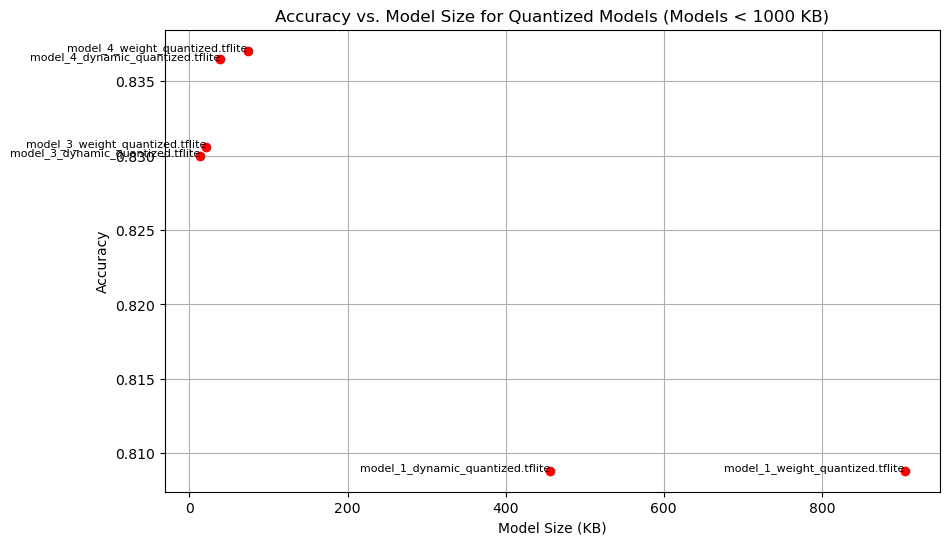

In [42]:
# List of quantized model filenames
quantized_model_filenames = []
for i in range(1, len(models) + 1):
    for strategy in ['weight', 'full', 'dynamic']:
        quantized_model_filenames.append(f'model_{i}_{strategy}_quantized.tflite')
    quantized_model_filenames.append(f'model_{i}_int16x8_quantized.tflite')

# Print sizes of quantized models and store the sizes
print("\nQuantized Model Sizes:")
quantized_model_sizes = print_quantized_model_sizes(quantized_model_filenames)

# Evaluate each quantized model and collect accuracies
quantized_accuracies = []

for model_filename, model_size in quantized_model_sizes:
    print(f'Evaluating {model_filename}')
    accuracy = evaluate_quantized_model(model_filename)
    quantized_accuracies.append((model_filename, model_size, accuracy))

# Filter accuracies for models smaller than 1000 KB and accuracy greater than 0.8
filtered_accuracies = [tup for tup in quantized_accuracies if tup[2] > 0.8 and tup[1] < 1000]

# Plot accuracy vs. model size for quantized models
model_names, model_sizes, accuracies = zip(*filtered_accuracies)

plt.figure(figsize=(10, 6))

# Plot points without connecting lines by setting linestyle='None'
plt.plot(model_sizes, accuracies, marker='o', linestyle='None', color='r')

# Annotate each point with the model name
for i, model_name in enumerate(model_names):
    plt.text(model_sizes[i], accuracies[i], model_name, fontsize=8, ha='right')

plt.xlabel('Model Size (KB)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Model Size for Quantized Models (Models < 1000 KB)')
plt.grid(True)
plt.show()
